# MOM6 input file idealised case

In [1]:
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import xarray as xr

In [2]:
# First define grid
NI, NJ, NK = 400, 200, 2 # number of points in zonal, meridional and vertical levels
LENLON, LENLAT = 1600., 800. # in km 
MAXIMUM_DEPTH = 4000.   # in m 
WESTLON, SOUTHLAT = 0.0, 0.0

X = np.linspace(WESTLON + LENLON/(NI*2), WESTLON + LENLON - LENLON/(2*NI), NI)
Y = np.linspace(SOUTHLAT + LENLAT/(NJ*2), SOUTHLAT + LENLAT - LENLAT/(NJ*2), NJ)
#Z = [k for k in range(NK)]

Xm, Ym = np.meshgrid(X,Y)

In [8]:
def flat_bottom():
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    return D

def Navid_ridge_bottom(H0, sigma):
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    ridge = np.exp(-((Xm - LENLON/6)/sigma)**2) + np.exp(-((Xm - 2*LENLON/6)/sigma)**2) \
    + np.exp(-((Xm - 3*LENLON/6)/sigma)**2) + np.exp(-((Xm - 4*LENLON/6)/sigma)**2) \
    + np.exp(-((Xm - 5*LENLON/6)/sigma)**2)
    ridge = ridge*H0/np.max(ridge)
    D = D - ridge
    return D

def guassian_ridge_bottom(H0, sigma):
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    ridge = np.exp(-((Xm - LENLON/2)/sigma)**2)
    ridge = ridge - np.min(ridge)
    ridge = ridge*H0/np.max(ridge)
    D = D - ridge
    return D

def sin_ridge_bottom(H0, n):
    D = MAXIMUM_DEPTH*np.ones((NJ,NI))
    ridge = np.sin(2*np.pi*n*Xm/LENLON - np.pi/2.)
    ridge = (H0/n)*ridge
    ridge[ridge < 0.] = 0. 
    D = D - ridge
    return D

def zero_velocity():
    u = np.zeros((NK,NJ,NI))
    v = np.zeros((NK,NJ,NI))
    return u,v

def wind_stress(tau_0):
    taux = tau_0*np.sin(np.pi*Ym/LENLAT)**2
    #taux = taux - np.min(taux)
    tauy = np.zeros((NJ,NI))
    return taux, tauy

def wind_stress_Navid(tau_0):
    taux = tau_0*np.sin(np.pi*(Ym - 0*LENLAT/4.)/(3*LENLAT/4))**2
    taux[int(np.round(3*NJ/4)):,:] = 0.
    tauy = np.zeros((NJ,NI))
    return taux, tauy

# Returns an array h[k,j,i] representing the layer thickness of the k-th layer at (lat,lon) 
# and an array eta[k,j,i] with the heights of each interface.
# Note that h has NK values in the vertical while eta has NK+1 values.
# k = 0 is the surface layer, with increasing k descending down the layers.
# h[i,j,k] >= ANGSTROM, which is the minimum layer thickness.
# input : D[i,j], a two-dimensional array of the depth of the ocean.
def layer_thickness(eta0, depth):
    eta = np.zeros((NK+1,NJ,NI))
    h = np.zeros((NK,NJ,NI))
    
    eta[NK-1,:,:] = eta0[1]
    eta[NK,:,:] = - depth
    
    for k in range(0,NK):
        h[k,:,:] = eta[k,:,:] - eta[k+1,:,:]
        
    return h, eta

In [9]:
tau_0 = 0.15

ridge_h0 = 1000.
n_ridge = 5;

H1, H2 = (1000., 3000.)

Rd = 20000
f = -10**-4
gp = Rd**2*MAXIMUM_DEPTH*f**2/(H1*H2)

rho_0 = 1027.35
rho_1 = gp*rho_0/9.8 + rho_0

density = [rho_0, rho_1]

print(gp, density)

depth = sin_ridge_bottom(ridge_h0, n_ridge)
taux, tauy = wind_stress(tau_0)

eta0 = [0., -H1, -MAXIMUM_DEPTH]
h, eta = layer_thickness(eta0, depth)

0.005333333333333333 [1027.35, 1027.9091020408162]


In [12]:
print(h.shape, eta.shape)
#print(density)
#print(eta[2,:,:])
np.min(taux)

(2, 200, 400) (3, 200, 400)


9.252563875455101e-06

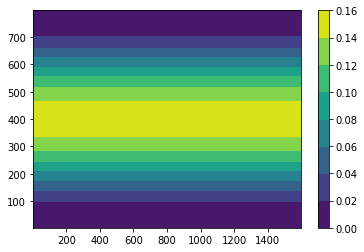

In [11]:
plt.contourf(X,Y,taux)
plt.colorbar()

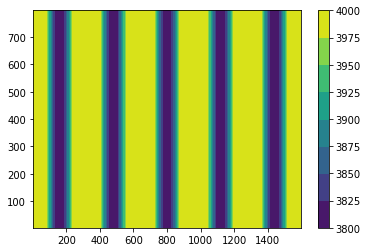

In [14]:
plt.contourf(X,Y,depth)
plt.colorbar()

#plt.plot(Y, tau_0*np.sin(np.pi*Y/LENLAT)**2)
#plt.plot(Y, tau_0*np.sin(2*np.pi*Y/LENLAT))

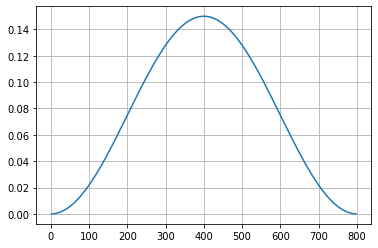

In [13]:
plt.plot(Y, taux[:,0])
plt.grid()

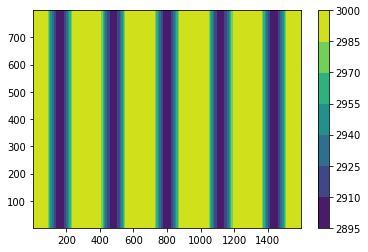

In [49]:
plt.contourf(X,Y,h[1,:,:])
plt.colorbar()

In [15]:
# Save data to nc file
ds = xr.Dataset(
        data_vars={'taux':    (('lat', 'lon'), taux),
                   'tauy': (('lat', 'lon'), tauy),
                   'depth':    (('lat', 'lon'), depth),
                  'h': (('level', 'lat', 'lon'), h),
                  'eta': (('interface','lat', 'lon'), eta)},
        coords={'lat': Y, 'lon': X, 'depth_list': eta0, 'level': density})

ds.lat.attrs['units'] = 'km'
ds.lon.attrs['units'] = 'km'
ds.depth_list.attrs['units'] = 'm'
ds.level.attrs['units'] = 'kg m-3'
ds.depth.attrs['units'] = 'm'
ds.taux.attrs['units'] = 'N m-2'
ds.tauy.attrs['units'] = 'N m-2'
ds.h.attrs['units'] = 'm'
ds.eta.attrs['units'] = 'm'

ds.lon.attrs['standard_name'] = 'Longitude'
ds.lat.attrs['standard_name'] = 'Latitude'
ds.depth_list.attrs['standard_name'] = 'Mean Interface Height'
ds.level.attrs['standard_name'] = 'Mean Layer Density'
ds.depth.attrs['standard_name'] = 'Total Depth'
ds.taux.attrs['standard_name'] = 'Zonal Wind Stress'
ds.tauy.attrs['standard_name'] = 'Meridional Wind Stress'
ds.h.attrs['standard_name'] = 'Layer Depth'
ds.eta.attrs['standard_name'] = 'Interface Height'

file = '/home/Hemant.Khatri/Work/MOM6_input/input_H_' + str(round(ridge_h0)) + '_n_' + str(round(n_ridge)) + '.nc'
ds.to_netcdf(path=file)

In [58]:
ds

<xarray.Dataset>
Dimensions:     (depth_list: 3, interface: 3, lat: 400, level: 2, lon: 800)
Coordinates:
  * lat         (lat) float64 1.0 3.0 5.0 7.0 9.0 ... 793.0 795.0 797.0 799.0
  * lon         (lon) float64 1.0 3.0 5.0 7.0 ... 1.595e+03 1.597e+03 1.599e+03
  * depth_list  (depth_list) float64 0.0 -1e+03 -4e+03
  * level       (level) float64 1.027e+03 1.028e+03
Dimensions without coordinates: interface
Data variables:
    taux        (lat, lon) float64 0.0 0.0 0.0 ... 3.79e-19 3.79e-19 3.79e-19
    tauy        (lat, lon) float64 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    depth       (lat, lon) float64 4e+03 4e+03 4e+03 4e+03 ... 4e+03 4e+03 4e+03
    h           (level, lat, lon) float64 1e+03 1e+03 1e+03 ... 3e+03 3e+03
    eta         (interface, lat, lon) float64 0.0 0.0 0.0 ... -4e+03 -4e+03

In [10]:
# Baroclinic Rossby deformation radius
rho1, rho2 = (1027.35, 1027.9)
H1, H2 = (1000., 3000.)
fo = 10**-4
gp = 9.8*(rho2-rho1)/rho1

Rd = np.sqrt(gp*H1*H2/(H1+H2))/fo

print(gp, Rd)



0.00524650800603668 19836.53448697002


In [43]:
np.round(3*LENLAT/(4*NJ))

3.0

In [36]:
file = '/nbhome/Hemant.Khatri/Work/input_H_' + str(round(ridge_h0)) + '_sigma_' + str(round(sigma)) + '.nc'
file

'/nbhome/Hemant.Khatri/Work/input_H_400_sigma_600.nc'